# Predicting Airbnb Rental Prices in Sydney Using Public Open Data – A Realistic and Transparent Approach

## Project Description

This project aims to predict nightly Airbnb rental prices in Sydney using the Inside Airbnb open dataset.

The model uses property features such as room type, number of bedrooms, availability, and location to make price predictions.

This type of analysis can support local governments in understanding short-term rental trends, identifying housing pressure zones, and planning tourism-related regulations.

## Dataset Source:

Inside Airbnb - Sydney

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
from geopy.distance import geodesic
from haversine import haversine

In [2]:
data = pd.read_csv("airbnb_with_sentiment.csv")

In [3]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg_sentiment_score
0,27787684,Camper/RV in Blacktown · 1 bedroom · 2 beds · ...,59663851,Anna,NaN,Blacktown,-33.77872,150.922340,Entire home/apt,39.0,90,0,NaN,NaN,2,0,0,NaN,0.000000
1,690779993276185834,Home in Avalon Beach · 6 bedrooms · 7 beds · 5...,8599740,Amelia,NaN,Pittwater,-33.63190,151.329020,Entire home/apt,2600.0,7,0,NaN,NaN,1,350,0,PID-STRA-38902,0.000000
2,30974325,Rental unit in Zetland · ★4.65 · 2 bedrooms · ...,84899994,Cheng,NaN,Sydney,-33.90568,151.206990,Entire home/apt,187.0,2,80,2023-08-04,1.34,3,14,30,PID-STRA-46397,0.349343
3,998317578882733226,Home in Forest Lodge · ★4.50 · 1 bedroom · 2 b...,516932091,Damon,NaN,Sydney,-33.88386,151.180388,Private room,88.0,1,12,2023-12-09,6.43,4,14,12,Exempt,0.000000
4,10299907,Rental unit in Potts Point · 1 bedroom · 1 bed...,52994567,Matthewsydsmith,NaN,Sydney,-33.87286,151.224350,Private room,80.0,90,1,2016-01-27,0.01,1,0,0,NaN,0.000000


In [5]:
data["beds"] = data["name"].str.extract(r'(\d+)\s*beds?', flags=re.IGNORECASE).astype(float)
data["bathrooms"] = data["name"].str.extract(r'(\d+)\s*baths?', flags=re.IGNORECASE).astype(float)

In [7]:
if 'neighbourhood' in data.columns and 'latitude' in data.columns and 'longitude' in data.columns:
    suburb_centers = data.groupby("neighbourhood")[["latitude", "longitude"]].mean()
    def compute_distance(row):
        if pd.notnull(row["latitude"]) and pd.notnull(row["longitude"]):
            center = suburb_centers.loc[row["neighbourhood"]]
            return geodesic((row["latitude"], row["longitude"]), (center["latitude"], center["longitude"])).km
        return np.nan
    data["distance_to_suburb_center"] = data.apply(compute_distance, axis=1)

In [10]:
landmarks = {
    "Sydney Opera House": (-33.8568, 151.2153),
    "Harbour Bridge": (-33.8523, 151.2108),
    "Bondi Beach": (-33.8908, 151.2743),
    "Darling Harbour": (-33.8748, 151.1987),
    "Taronga Zoo": (-33.8434, 151.2410),
    "The Rocks": (-33.8599, 151.2091),
    "Royal Botanic Garden": (-33.8642, 151.2166),
    "Manly Beach": (-33.8001, 151.2883),
    "Circular Quay": (-33.8612, 151.2108),
    "Queen Victoria Building": (-33.8714, 151.2068)
}

In [12]:
for name, coords in landmarks.items():
    data[f"distance_to_{name.replace(' ', '_').lower()}"] = data.apply(
        lambda row: haversine((row["latitude"], row["longitude"]), coords),
        axis=1
    )

In [17]:
data["weighted_sentiment"] = (
    data["avg_sentiment_score"] * data["number_of_reviews"]
)

## season-price relationship

In [19]:
data["last_review"] = pd.to_datetime(data["last_review"], errors='coerce')

In [20]:
data["review_month"] = data["last_review"].dt.month
data["review_weekday"] = data["last_review"].dt.weekday  # 0=Monday
data["review_weekend"] = data["review_weekday"].apply(lambda x: 1 if x >= 5 else 0)

In [21]:
def get_season(month):
    if month in [12, 1, 2]:
        return "summer"
    elif month in [3, 4, 5]:
        return "autumn"
    elif month in [6, 7, 8]:
        return "winter"
    elif month in [9, 10, 11]:
        return "spring"
    else:
        return None

data["season"] = data["review_month"].apply(get_season)

In [22]:
data["is_summer"] = (data["season"] == "summer").astype(int)
data["is_winter"] = (data["season"] == "winter").astype(int)

In [24]:
data.groupby("season")["price"].agg(["mean", "median", "count"]).sort_values("mean", ascending=False)

,mean,median,count
season,,,
summer,306.996429,195.0,6720
spring,286.813884,209.0,7044
autumn,267.711887,158.0,2204
winter,261.378646,163.0,1920


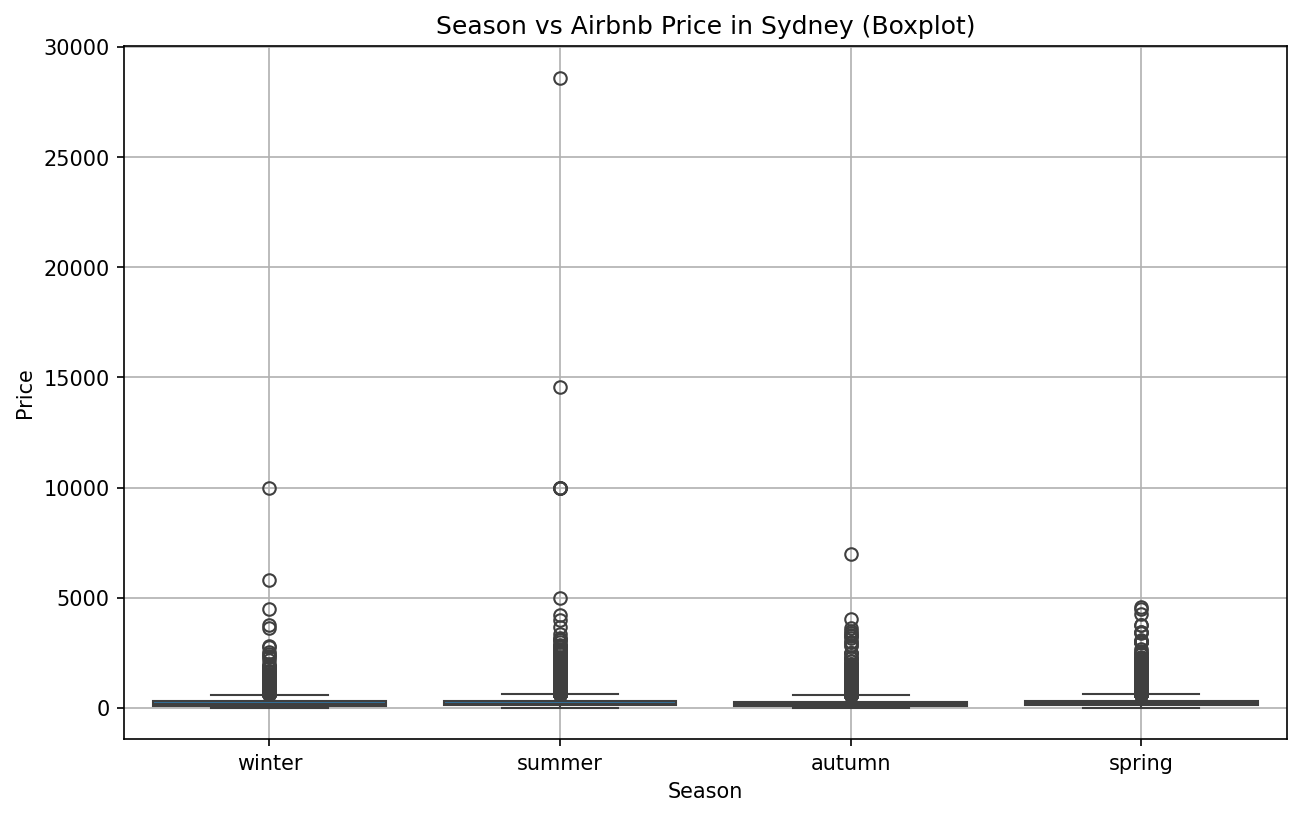

In [26]:
plt.figure(figsize=(10, 6), dpi=150)
sns.boxplot(data=data, x='season', y='price')
plt.title("Season vs Airbnb Price in Sydney (Boxplot)")
plt.ylabel("Price")
plt.xlabel("Season")
plt.grid(True)
plt.show()

In [28]:
data[data["season"] == "summer"][["name", "price", "neighbourhood"]].sort_values(by="price", ascending=False).head(10)

,name,price,neighbourhood
6673,Home in Paddington · 1 bedroom · 1 bed · 2 baths,28613.0,Woollahra
12374,Rental unit in Chatswood · ★4.71 · Studio · 0 ...,14568.0,Willoughby
2676,Villa in South Coogee · 5 bedrooms · 5 beds · ...,10000.0,Randwick
19852,Bungalow in Chippendale · 1 bedroom · 1 shared...,10000.0,Sydney
24486,Home in Clareville · ★4.74 · 3 bedrooms · 2 baths,10000.0,Pittwater
11193,Rental unit in Surry Hills · ★4.70 · 2 bedroom...,9999.0,Sydney
13110,Rental unit in St. Leonards · ★4.70 · 2 bedro...,5000.0,Willoughby
18463,Boat in Balgowlah · ★5.0 · 3 bedrooms · 3 beds...,4200.0,Manly
12008,Home in Bronte · 4 bedrooms · 5 beds · 4.5 baths,4000.0,Waverley
3208,Home in Newport · 5 bedrooms · 5 beds · 4 baths,3672.0,Pittwater


In [31]:
data = data[~((data["season"] == "summer") & (data["price"] > 5000))]

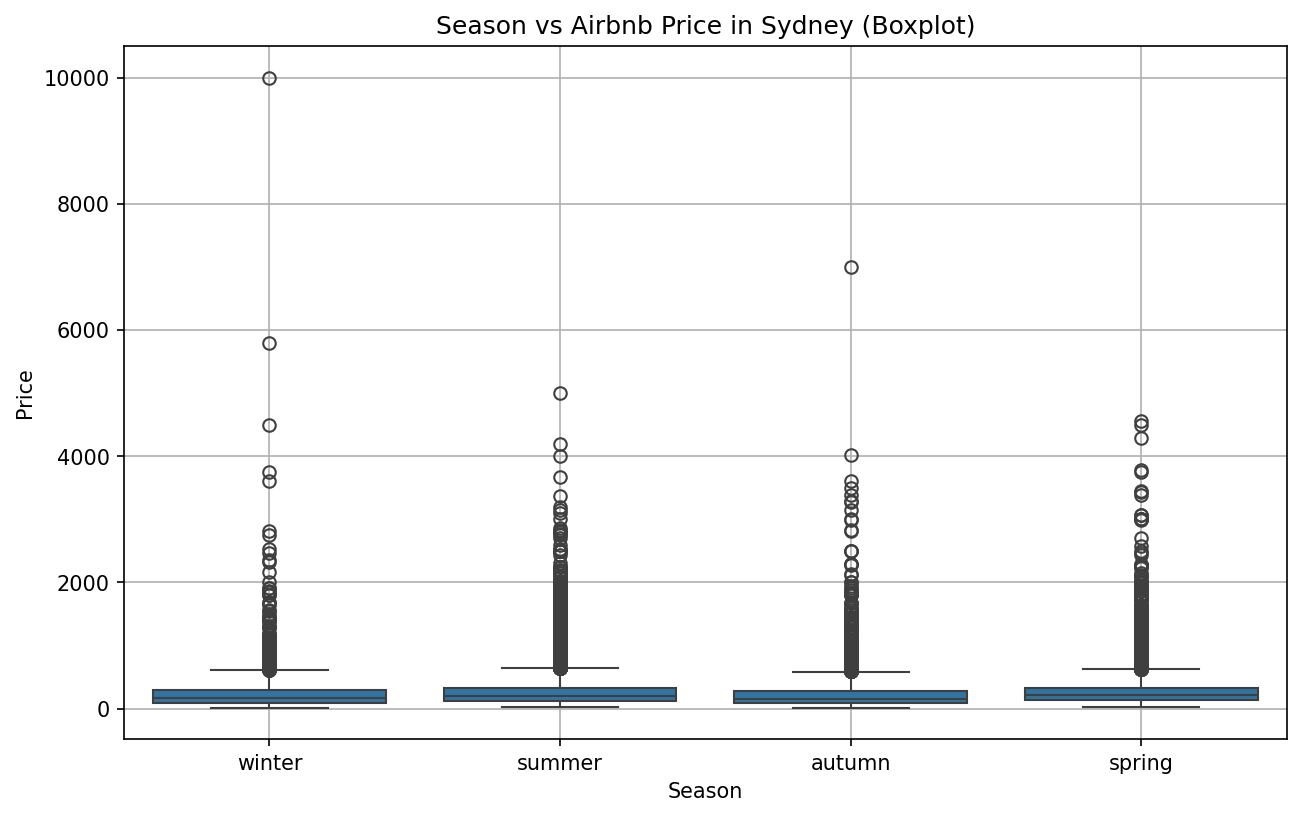

In [33]:
plt.figure(figsize=(10, 6), dpi=150)
sns.boxplot(data=data, x='season', y='price')
plt.title("Season vs Airbnb Price in Sydney (Boxplot)")
plt.ylabel("Price")
plt.xlabel("Season")
plt.grid(True)
plt.show()

In [38]:
drop_cols = [
    "id", "name", "host_id", "host_name", "neighbourhood_group", "neighbourhood",
    "last_review", "license", "review_month", "review_weekday", "review_weekend", "number_of_reviews_ltm",
    "is_summer", "is_winter"
]

data_cleaned = data.drop(columns=drop_cols)

In [39]:
data_cleaned.isnull().sum()

latitude                                  0
longitude                                 0
room_type                                 0
price                                  1098
minimum_nights                            0
number_of_reviews                         0
reviews_per_month                      7205
calculated_host_listings_count            0
availability_365                          0
avg_sentiment_score                       0
beds                                     56
bathrooms                              5375
distance_to_suburb_center                 0
distance_to_sydney_opera_house            0
distance_to_harbour_bridge                0
distance_to_bondi_beach                   0
distance_to_darling_harbour               0
distance_to_taronga_zoo                   0
distance_to_the_rocks                     0
distance_to_royal_botanic_garden          0
distance_to_manly_beach                   0
distance_to_circular_quay                 0
distance_to_queen_victoria_build

In [41]:
data_cleaned = data_cleaned.dropna(subset=["price", "beds", "bathrooms", "season"])

### bathroom_ratio feature

In [50]:
data_cleaned["bathroom_ratio"] = data_cleaned["bathrooms"] / (data_cleaned["beds"] + 1)

In [55]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14373 entries, 2 to 25479
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   latitude                             14373 non-null  float64
 1   longitude                            14373 non-null  float64
 2   room_type                            14373 non-null  object 
 3   price                                14373 non-null  float64
 4   minimum_nights                       14373 non-null  int64  
 5   number_of_reviews                    14373 non-null  int64  
 6   reviews_per_month                    14373 non-null  float64
 7   calculated_host_listings_count       14373 non-null  int64  
 8   availability_365                     14373 non-null  int64  
 9   avg_sentiment_score                  14373 non-null  float64
 10  beds                                 14373 non-null  float64
 11  bathrooms                        

## Encoding:

In [65]:
data_encoded = pd.get_dummies(data_cleaned, columns=["room_type", "season"], drop_first=True)

In [67]:
print(data_encoded.dtypes)

latitude                               float64
longitude                              float64
price                                  float64
minimum_nights                           int64
number_of_reviews                        int64
reviews_per_month                      float64
calculated_host_listings_count           int64
availability_365                         int64
avg_sentiment_score                    float64
beds                                   float64
bathrooms                              float64
distance_to_suburb_center              float64
distance_to_sydney_opera_house         float64
distance_to_harbour_bridge             float64
distance_to_bondi_beach                float64
distance_to_darling_harbour            float64
distance_to_taronga_zoo                float64
distance_to_the_rocks                  float64
distance_to_royal_botanic_garden       float64
distance_to_manly_beach                float64
distance_to_circular_quay              float64
distance_to_q

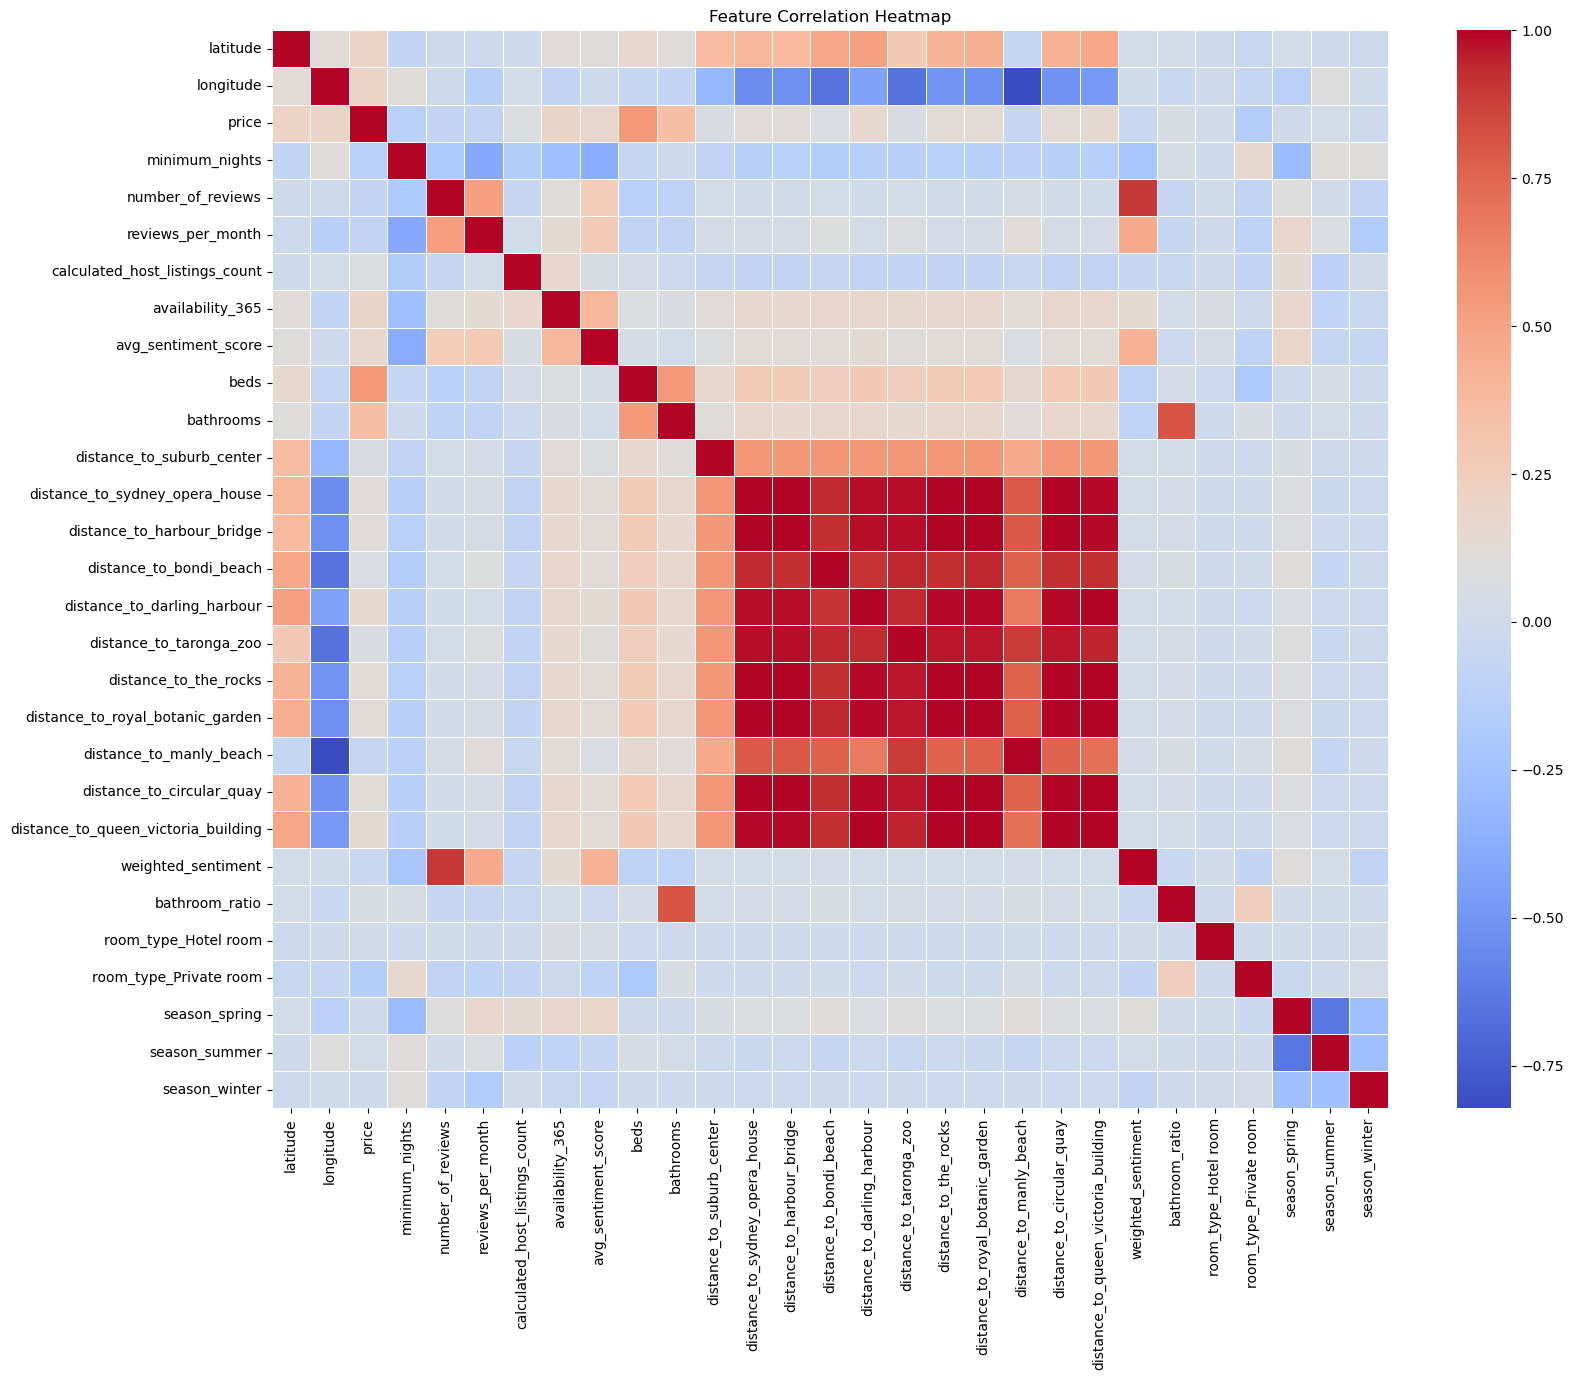

In [70]:
correlation_matrix = data_encoded.corr(numeric_only=True)

plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

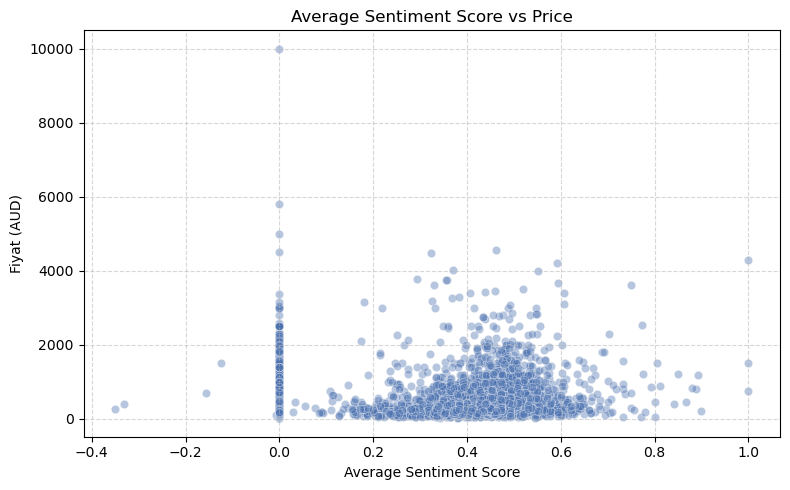

In [73]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=data_cleaned, x="avg_sentiment_score", y="price", alpha=0.4, color="#4C72B0")
plt.title("Average Sentiment Score vs Price")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Fiyat (AUD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Machine Learning Part

In [82]:
y = np.log1p(data_encoded["price"])
X = data_encoded.drop(columns=["price"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

### XGBoost

In [86]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_log = xgb_model.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 242.65
MAE: 103.61
R² Score: 0.52


<Figure size 3200x1200 with 0 Axes>

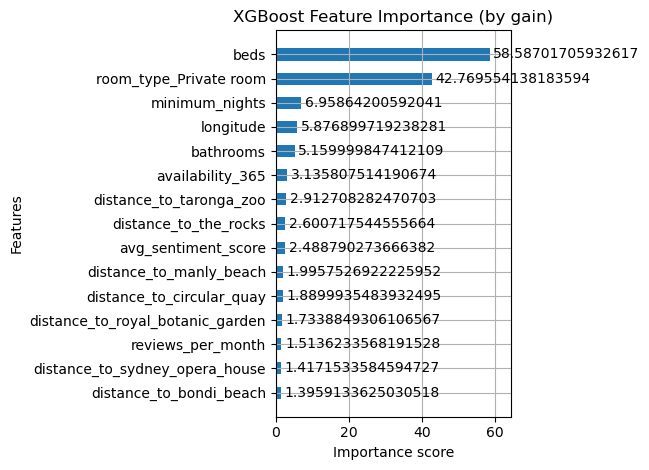

In [89]:
import matplotlib.pyplot as plt
import xgboost as xgb

plt.figure(figsize=(16,6), dpi=200)
xgb.plot_importance(xgb_model, max_num_features=15, height=0.5, importance_type='gain')
plt.title("XGBoost Feature Importance (by gain)")
plt.tight_layout()
plt.show()

## XGBoost Hyperparameter Tuning

In [93]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4)
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
En iyi parametreler: {'colsample_bytree': 0.7599443886861021, 'learning_rate': 0.023999698964084628, 'max_depth': 6, 'n_estimators': 370, 'subsample': 0.7824279936868144}
En iyi skor (neg RMSE): -0.3837024118744104


In [95]:
best_xgb = XGBRegressor(
    colsample_bytree=0.7599443886861021,
    learning_rate=0.023999698964084628,
    max_depth=6,
    n_estimators=370,
    subsample=0.7824279936868144,
    random_state=42
)

best_xgb.fit(X_train, y_train)

y_pred_log = best_xgb.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

RMSE: 241.11024996200092
MAE: 102.28270430589758
R² Score: 0.523946712958377


# LightGBM

In [99]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

lgb_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)

y_pred_log_lgb = lgb_model.predict(X_test)
y_pred_lgb = np.expm1(y_pred_log_lgb)
y_true_lgb = np.expm1(y_test)

rmse_lgb = np.sqrt(mean_squared_error(y_true_lgb, y_pred_lgb))
mae_lgb = mean_absolute_error(y_true_lgb, y_pred_lgb)
r2_lgb = r2_score(y_true_lgb, y_pred_lgb)

print(f"RMSE: {rmse_lgb:.2f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"R² Score: {r2_lgb:.3f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4727
[LightGBM] [Info] Number of data points in the train set: 11498, number of used features: 27
[LightGBM] [Info] Start training from score 5.500022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

# RandomForestRegressor:

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_log_rf = rf_model.predict(X_test)

y_pred_rf = np.expm1(y_pred_log_rf)
y_true_rf = np.expm1(y_test)

rmse_rf = np.sqrt(mean_squared_error(y_true_rf, y_pred_rf))
mae_rf = mean_absolute_error(y_true_rf, y_pred_rf)
r2_rf = r2_score(y_true_rf, y_pred_rf)

print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.3f}")

RMSE: 248.17
MAE: 108.24
R² Score: 0.496


## Model Performance Comparison

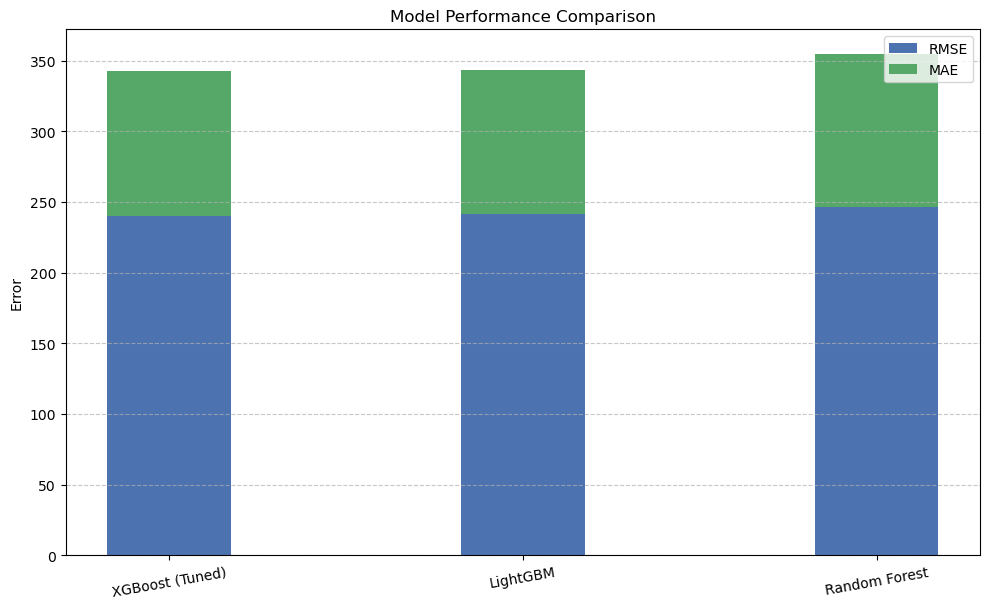

In [104]:
results_df = pd.read_csv("Model_Performance_Comparison.csv")

# Renk paleti
colors = ["#4C72B0", "#55A868", "#C44E52"]

# RMSE ve MAE Bar Plot
plt.figure(figsize=(10, 6))
x = results_df["Model"]
rmse = results_df["RMSE"]
mae = results_df["MAE"]

bar_width = 0.35
bar1 = plt.bar(x, rmse, width=bar_width, label="RMSE", color=colors[0])
bar2 = plt.bar(x, mae, width=bar_width, label="MAE", color=colors[1], bottom=rmse)

plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=10)
plt.show()

## SHAP Analysis

In [109]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

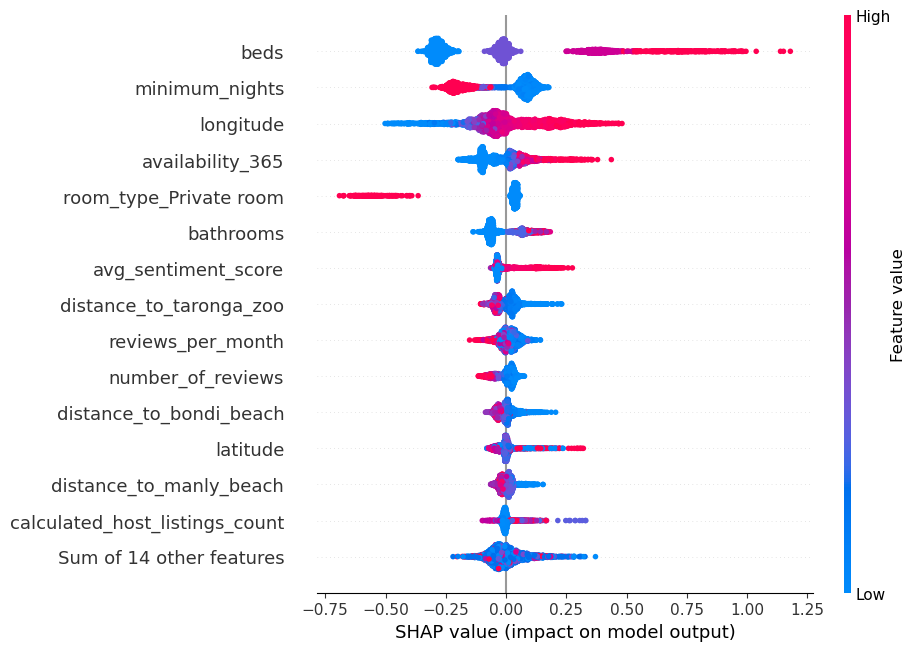

In [111]:
shap.plots.beeswarm(shap_values, max_display=15)
plt.show()

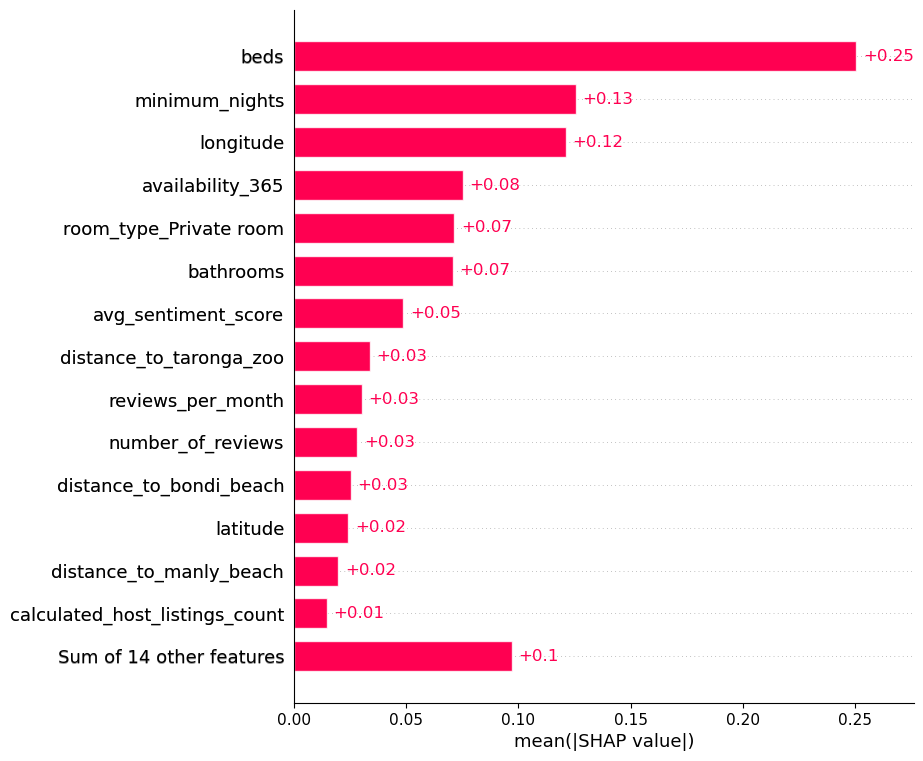

In [113]:
shap.plots.bar(shap_values, max_display=15)